In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [10]:
def calculate_price_movement(start_day: pd.Timestamp, end_day: pd.Timestamp) -> dict[str: pd.DataFrame]:
    df_main_sheet = pd.DataFrame()
    df_detailed_sheet = pd.DataFrame()

    for day in pd.date_range(start_day, end_day):
        df_main_sheet = pd.concat(
            [
                df_main_sheet, 
                pd.read_excel(
                    f"daily_results/ДобовіРезультатиРДН_ОЕС_2024_{day.month:02d}_{day.day:02d}.xlsx",
                    sheet_name="Добові результати РДН - ОЕС",
                )
            ]
        )
        df_detailed_sheet = pd.concat(
            [
                df_detailed_sheet, 
                pd.read_excel(
                    f"daily_results/ДобовіРезультатиРДН_ОЕС_2024_{day.month:02d}_{day.day:02d}.xlsx", 
                    sheet_name="Точки кривої - ОЕС",
                )
            ]
        )
    return {"main_sheet": df_main_sheet, "detailed_sheet": df_detailed_sheet}


dict_of_df = calculate_price_movement(pd.Timestamp(2024, 10, 1), pd.Timestamp(2024, 10, 19))

df_main = dict_of_df["main_sheet"]
df_detailed = dict_of_df["detailed_sheet"]

df_main = df_main.rename(columns={"Не успішна пропозиція - Обсяг (МВт*год)": "Неуспішна пропозиція - Обсяг (МВт*год)",}, errors="raise")
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 23
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Дата                                    456 non-null    datetime64[ns]
 1   Розрахунковий Період                    456 non-null    int64         
 2   Регіональна ціна                        456 non-null    float64       
 3   Акцептовані продаж - Обсяг (МВт*год)    456 non-null    float64       
 4   Неуспішна пропозиція - Обсяг (МВт*год)  456 non-null    float64       
 5   Акцептовані продаж - Кількість          456 non-null    int64         
 6   Неуспішна пропозиція - Кількість        456 non-null    int64         
 7   Акцептовані купівлю - Обсяг (МВт*год)   456 non-null    float64       
 8   Неуспішний попит - Обсяг (МВт*год)      456 non-null    float64       
 9   Акцептовані купівлю - Кількість         456 non-null    int6

In [11]:
df_main_average_by_date = (
    df_main.groupby("Дата").mean().drop(columns=["Розрахунковий Період"])
)

### Correlation

In [12]:
df_correlation = df_main_average_by_date.corr()[["Регіональна ціна"]]
df_correlation_strong = df_correlation[
    (df_correlation["Регіональна ціна"].abs() > 0.8)
]

df_correlation_strong

,Регіональна ціна
Регіональна ціна,1.000000
Акцептовані продаж - Обсяг (МВт*год),0.850678
Неуспішна пропозиція - Обсяг (МВт*год),-0.879525
Акцептовані продаж - Кількість,0.865910
Неуспішна пропозиція - Кількість,-0.945545
Акцептовані купівлю - Обсяг (МВт*год),0.850678
Загальний купівлю - Обсяг (МВт*год),0.841682


### Line chart

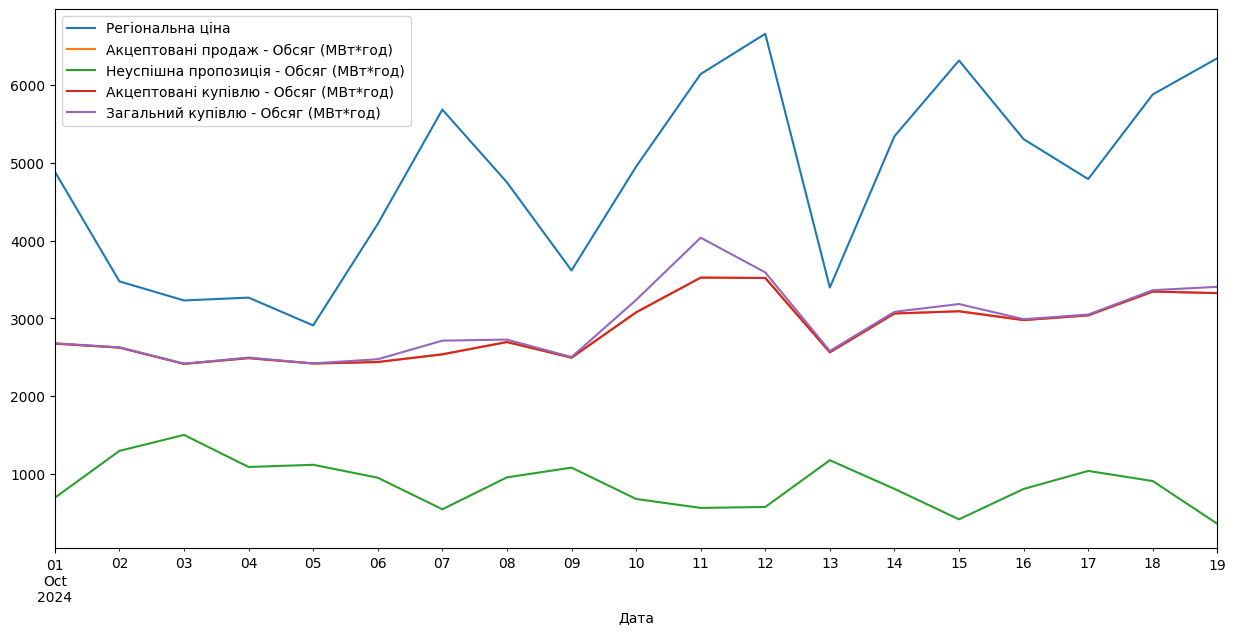

In [13]:
remove_amount = df_main_average_by_date[
    df_correlation_strong.index
].drop(
    columns=[
        "Акцептовані продаж - Кількість", 
        "Неуспішна пропозиція - Кількість"
    ]
)

line_chart = remove_amount.plot(kind="line", figsize=(15, 7))

# Attempt to make an ML regression model to predict price movement in the future.

In [14]:
df_main_average_by_date['Price Movement'] = (
        (
                df_main_average_by_date['Регіональна ціна'].shift(-1) -
                df_main_average_by_date['Регіональна ціна']
        ) > 0
)
df_main_average_by_date['Price Movement'] = (
    df_main_average_by_date['Price Movement'].astype(int)
)
df = df_main_average_by_date

In [15]:
# Select relevant features
features = [
    'Регіональна ціна', 
    'Акцептовані продаж - Кількість', 
    'Неуспішна пропозиція - Кількість',
    'Неуспішна пропозиція - Обсяг (МВт*год)',
    'Загальний купівлю - Кількість',
    'Загальний купівлю - Обсяг (МВт*год)'
]
# Create lagged features
for feature in features:
    df[f'lag_{feature}'] = df[feature].shift(1)

# Drop the NaN values created from the shift operation
df.dropna(inplace=True)

In [16]:
# Define the features and target
X = df[[f'lag_{feature}' for feature in features]]
y = df['Price Movement']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Train a logistic regression model

In [17]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Make a prediction for October 20 based on the latest available data (October 19)

In [18]:
latest_data = pd.DataFrame(df.iloc[-1][[f'lag_{feature}' for feature in features]]).T
latest_data.columns = [f'lag_{feature}' for feature in features]
predicted_prob = model.predict_proba(latest_data)[0]

print(f"price increase probability: {(predicted_prob[1] * 100).round(2)}%\n"
      f"price decrease probability: {(predicted_prob[0] * 100).round(2)}%")

price increase probability: 12.22%
price decrease probability: 87.78%


### Evaluate on test set

In [19]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=5)

print("Test Set Accuracy: {:.2f}".format(accuracy))
print("Mean Cross-Validation Score: {:.2f}".format(cross_val_scores.mean()))

Test Set Accuracy: 0.60
Mean Cross-Validation Score: 0.62


So in the end my conclusion is that it's better to avoid using this model due to low accuracy. The reason for it's low accuracy probably to lack of input data.